## Predict 2 meter temperature with sea surface temperature using autoencoder with multi-head attention
This notebook serves as an example of a basic workflow of data driven forecasting using deep learning with `s2spy` & `lilio` packages. <br>
We will predict temperature in US at seasonal time scales using ERA5 dataset with multi-head attention autoencoder. <br>

<img src="../assets/concept_test_case.png" alt="usecase" width="500"/>

This recipe includes the following steps:
- Define a calendar (`lilio`)
- Download/load input data (test data, accessible via `era5cli`)
- Map the calendar to the data (`lilio`)
- Train-validate-test split (60%/20%/20%)
- Preprocessing based on the training set (`s2spy`)
- Resample data to the calendar (`lilio`)
- Create autoencoder model (`torch`)
- Specify hyper-parameters (`wandb`)
- Train model (`torch`)
- Evaludate model

The workflow is illustrated below:

<img src="../assets/dl.PNG" alt="Transformer" width="900"/>

In [1]:
import lilio
import numpy as np
import sys
import time as tt
import wandb
import xarray as xr
from pathlib import Path
from s2spy import preprocess
import torch
from torch import nn
from torch import Tensor
import torch.nn.functional as f

sys.path.append("../src/")
from autoencoder import Transformer
import utils

#### Define a calendar with `lilio` to specify time range for targets and precursors.

In [2]:
# create custom calendar based on the time of interest
calendar = lilio.Calendar(anchor="07-01", allow_overlap=True)
# add target periods
calendar.add_intervals("target", length="30d", gap="1M")
# add precursor periods
periods_of_interest = 8
calendar.add_intervals("precursor", "1M", n=periods_of_interest)

In [3]:
# check calendar
calendar

Calendar(
    anchor='07-01',
    allow_overlap=True,
    mapping=None,
    intervals=[
        Interval(role='target', length='30d', gap='1M'),
        Interval(role='precursor', length='1M', gap='0d'),
        Interval(role='precursor', length='1M', gap='0d'),
        Interval(role='precursor', length='1M', gap='0d'),
        Interval(role='precursor', length='1M', gap='0d'),
        Interval(role='precursor', length='1M', gap='0d'),
        Interval(role='precursor', length='1M', gap='0d'),
        Interval(role='precursor', length='1M', gap='0d'),
        Interval(role='precursor', length='1M', gap='0d')
    ]
)

#### Load test data SST and (clustered) T2M
For the sake of batch size, we use 61 years (1961-2021) of data.

In [4]:
# load data
precursor_field = xr.open_dataset('../data/sst_daily_1959-2021_5deg_Pacific_175_240E_25_50N.nc')
precursor_field = precursor_field.sel(time=slice("19610101","20211231"))
target_field = xr.open_dataset('../data/t2m_daily_1959-2021_2deg_clustered_226_300E_30_70N.nc')
target_field = target_field.sel(time=slice("19610101","20211231"))

In [5]:
# Convert Klevin to Celcius
precursor_field["sst"] = precursor_field["sst"] - 273.15
target_field["t2m"] = target_field["t2m"] - 273.15

#### Map the calendar to the data
After mapping the calendar to the field, we can visualize our calendar by calling the `visualize` method.

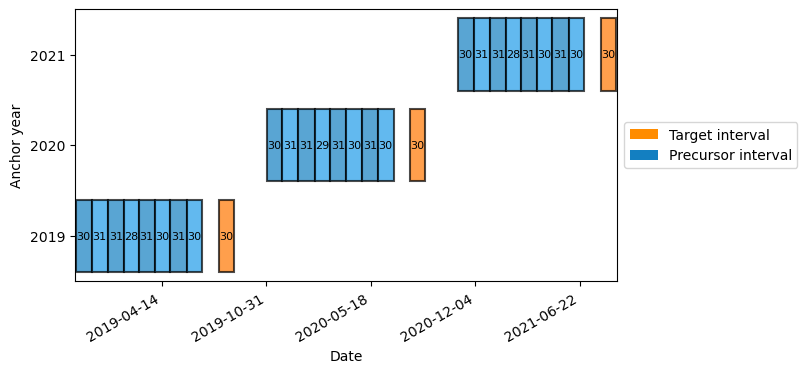

In [6]:
# map calendar to data
calendar.map_to_data(precursor_field)
calendar.visualize(show_length=True)

Also, we can get a list of all intervals by running the following line. There, you will find the intervals `-1` and `1`, which corresponds to the creation of a precursor interval (negative integer(s)) and a target interval (positive integer(s)), respectively. <br>

For more information about the definition of intervals, and how `lilio` works, please check the [README](https://github.com/AI4S2S/lilio) of `lilio`.

In [7]:
calendar.show()[:3]

i_interval,-8,-7,-6,-5,-4,-3,-2,-1,1
anchor_year,,,,,,,,,
2021,"[2020-11-01, 2020-12-01)","[2020-12-01, 2021-01-01)","[2021-01-01, 2021-02-01)","[2021-02-01, 2021-03-01)","[2021-03-01, 2021-04-01)","[2021-04-01, 2021-05-01)","[2021-05-01, 2021-06-01)","[2021-06-01, 2021-07-01)","[2021-08-01, 2021-08-31)"
2020,"[2019-11-01, 2019-12-01)","[2019-12-01, 2020-01-01)","[2020-01-01, 2020-02-01)","[2020-02-01, 2020-03-01)","[2020-03-01, 2020-04-01)","[2020-04-01, 2020-05-01)","[2020-05-01, 2020-06-01)","[2020-06-01, 2020-07-01)","[2020-08-01, 2020-08-31)"
2019,"[2018-11-01, 2018-12-01)","[2018-12-01, 2019-01-01)","[2019-01-01, 2019-02-01)","[2019-02-01, 2019-03-01)","[2019-03-01, 2019-04-01)","[2019-04-01, 2019-05-01)","[2019-05-01, 2019-06-01)","[2019-06-01, 2019-07-01)","[2019-08-01, 2019-08-31)"


#### Train-validate-test split based on the anchor years (60%/20%/20% split)

In [8]:
# get 60% of instance as training
years = sorted(calendar.get_intervals().index)
train_samples = round(len(years) * 0.6)
test_samples = round(len(years) * 0.2)
start_year = years[0]

#### Fit preprocessor with training samples and preprocess data
Remove trend and take anomalies for the precursor field.

In [9]:
# create preprocessor
preprocessor = preprocess.Preprocessor(
    rolling_window_size=25,
    detrend="linear",
    subtract_climatology=True,
)

# fit preprocessor with training data
preprocessor.fit(
    precursor_field.sel(
        time=slice(str(start_year), str(start_year + train_samples - 1))
    )
)

In [10]:
# preprocess the whole precursor field
precursor_field_prep = preprocessor.transform(precursor_field)

Resample data to the calendar

In [11]:
precursor_field_resample = lilio.resample(calendar, precursor_field_prep)
target_field_resample = lilio.resample(calendar, target_field)

In [12]:
# select variables and intervals
precursor_field_sel = precursor_field_resample['sst']
target_series_sel = target_field_resample['t2m'].sel(cluster=3)

In [13]:
# slice and reshape input desired by transformer
sequence_precursor = len(precursor_field_sel.i_interval) - 1 # we only take precursor parts of i intervals
lat_precursor = len(precursor_field_sel.latitude)
lon_precursor = len(precursor_field_sel.longitude)

X_torch = torch.from_numpy(precursor_field_sel[:,:-1,:,:].data).type(torch.FloatTensor)
y_torch = torch.from_numpy(target_series_sel[:,-1].data).type(torch.FloatTensor)

X_torch = X_torch.view(-1, sequence_precursor, lat_precursor*lon_precursor)

# turn nan to 0.0
X_torch = torch.nan_to_num(X_torch, 0.0)

In [14]:
# train/validate/test split and use pytorch dataloader
train_X_torch = X_torch[:train_samples]
train_y_torch = y_torch[:train_samples]

valid_X_torch = X_torch[train_samples:train_samples + test_samples]
valid_y_torch = y_torch[train_samples:train_samples + test_samples]

test_X_torch = X_torch[-test_samples:]
test_y_torch = y_torch[-test_samples:]

# pytorch train and test sets
train_set = torch.utils.data.TensorDataset(train_X_torch, train_y_torch)
valid_set = torch.utils.data.TensorDataset(valid_X_torch, valid_y_torch)
test_set = torch.utils.data.TensorDataset(test_X_torch, test_y_torch)

Print system info:

In [15]:
print ("Pytorch version {}".format(torch.__version__))
use_cuda = torch.cuda.is_available()
print("Is CUDA available? {}".format(use_cuda))
# use GPU if possible
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device to be used for computation: {}".format(device))

Pytorch version 2.0.1
Is CUDA available? False
Device to be used for computation: cpu


#### Hyper-parameter tuning with W&B
We use Weight&Biases to monitor the training process. It is very simple to integrate it into our workflow and more information about how to set it up can be found at https://docs.wandb.ai/quickstart. <br>

You'll need an account, a team, and a project if you'll want to track runs online. Otherwise, you can simply run the code by setting mode = 'disabled' (W&B will not be active). 

In [16]:
hyperparameters = dict(
    epoch = 150,
    num_encoder_layers = 1,
    dim_model = lat_precursor*lon_precursor,
    num_heads = 2,
    dim_feedforward = 12,
    dim_output = 1,
    batch_size = 4,
    dropout = 0.1,
    learning_rate = 0.01,
    periods_of_interest = periods_of_interest,
    dataset = 'Weather',
    architecture = 'Transformer'
)

# call weights & biases service
wandb.login()

# initialize weights & biases service
mode = 'disabled'
# mode = 'online' # <- uncomment this line to enable wandb
team = 'ai4s2s-demo' # <- your own team namehere
project = 'test-autoencoder' # <- your own project name here
wandb.init(config=hyperparameters, project=project, entity=team, mode=mode)
config = wandb.config

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: s-p-vijverberg (ai4s2s-demo). Use `wandb login --relogin` to force relogin


In [17]:
# create data loader and use batch 
train_loader = torch.utils.data.DataLoader(train_set, batch_size = config.batch_size, shuffle = False)
valid_loader = torch.utils.data.DataLoader(valid_set, batch_size = config.batch_size, shuffle = False)
test_loader = torch.utils.data.DataLoader(test_set, batch_size = config.batch_size, shuffle = False)

#### Initialize and train model
Create autoencoder. Initialize model and choose loss function and optimizer. <br>

The architecture of the autoencoder used here is shown in the figure below. This structure is very similar to the famous language model called BERT. For more details about the full transformer network structure, check the paper [BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding](https://arxiv.org/abs/1810.04805).

<img src="../assets/bert.png" alt="BERT" width="500"/>

In [18]:
# Initialize model
model = Transformer(num_encoder_layers = config["num_encoder_layers"],
                    dim_model = config["dim_model"], 
                    num_heads = config["num_heads"], 
                    dim_feedforward = config["dim_feedforward"], 
                    dim_output = config["dim_output"], 
                    dropout = config["dropout"])
# Specify loss function
criterion = nn.MSELoss()
# Choose optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=config.learning_rate)
# Print model and optimizer details
print('Model details:\n', model)
print('Optimizer details:\n',optimizer)
wandb.watch(model)

Model details:
 Transformer(
  (encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (attention): Residual(
          (sublayer): MultiHeadAttention(
            (heads): ModuleList(
              (0-1): 2 x AttentionHead(
                (q): Linear(in_features=65, out_features=32, bias=True)
                (k): Linear(in_features=65, out_features=32, bias=True)
                (v): Linear(in_features=65, out_features=32, bias=True)
              )
            )
            (linear): Linear(in_features=64, out_features=65, bias=True)
          )
          (norm): LayerNorm((65,), eps=1e-05, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (feed_forward): Residual(
          (sublayer): Sequential(
            (0): Linear(in_features=65, out_features=12, bias=True)
            (1): ReLU()
            (2): Linear(in_features=12, out_features=65, bias=True)
          )
          (norm): LayerNorm

[]

In [19]:
# display the total number of parameters
utils.total_num_param(model)
# for more details about the trainable parameter in each layer
#utils.param_trainable(model)

18860


Start the training loop.

In [20]:
# calculate the time for the code execution
start_time = tt.time()

# switch model into training mode
model.train()

hist_train = []
hist_valid = []
for epoch in range(config.epoch):
    # training loop
    # switch model into train mode
    model.train()
    hist_train_step = 0
    for batch_idx, (X_batch, y_batch) in enumerate(train_loader):
        var_X_batch = torch.autograd.Variable(X_batch).to(device)
        var_y_batch = torch.autograd.Variable(y_batch).to(device)
        optimizer.zero_grad()
        output = model(var_X_batch)
        loss = criterion(output.squeeze(), var_y_batch)
        loss.backward()
        optimizer.step()
        wandb.log({'train_loss': loss.item()})
        if batch_idx % 2 == 0:
            print(f'Epoch : {epoch} [{batch_idx*len(X_batch)}/{len(train_loader.dataset)}'
                  f'({100.* batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')
        hist_train_step += loss.item()

    hist_train.append(hist_train_step / len(train_loader.dataset))

    # cross-validation loop
    # switch model into evaluation mode
    model.eval()
    hist_valid_step = 0

    for batch_idx, (X_batch, y_batch) in enumerate(valid_loader):
        var_X_batch = torch.autograd.Variable(X_batch).to(device)
        var_y_batch = torch.autograd.Variable(y_batch).to(device)
        optimizer.zero_grad()
        with torch.no_grad():
            output = model(var_X_batch)
            loss = criterion(output.squeeze(), var_y_batch)
        wandb.log({'validation_loss': loss.item()})
        hist_valid_step += loss.item()

    hist_valid.append(hist_valid_step / len(valid_loader.dataset))

print (f"--- {(tt.time() - start_time)/60} minutes ---")

Epoch : 0 [0/36(0%)]	Loss: 514.437378
Epoch : 0 [8/36(22%)]	Loss: 375.684021
Epoch : 0 [16/36(44%)]	Loss: 318.399841
Epoch : 0 [24/36(67%)]	Loss: 266.961975
Epoch : 0 [32/36(89%)]	Loss: 212.988541
Epoch : 1 [0/36(0%)]	Loss: 175.764191
Epoch : 1 [8/36(22%)]	Loss: 146.588135
Epoch : 1 [16/36(44%)]	Loss: 114.187950
Epoch : 1 [24/36(67%)]	Loss: 79.877907
Epoch : 1 [32/36(89%)]	Loss: 48.396385
Epoch : 2 [0/36(0%)]	Loss: 29.274242
Epoch : 2 [8/36(22%)]	Loss: 16.765369
Epoch : 2 [16/36(44%)]	Loss: 7.300838
Epoch : 2 [24/36(67%)]	Loss: 1.983531
Epoch : 2 [32/36(89%)]	Loss: 2.387123
Epoch : 3 [0/36(0%)]	Loss: 3.642135
Epoch : 3 [8/36(22%)]	Loss: 6.103943
Epoch : 3 [16/36(44%)]	Loss: 8.462330
Epoch : 3 [24/36(67%)]	Loss: 9.279305
Epoch : 3 [32/36(89%)]	Loss: 8.575045
Epoch : 4 [0/36(0%)]	Loss: 8.518817
Epoch : 4 [8/36(22%)]	Loss: 2.147379
Epoch : 4 [16/36(44%)]	Loss: 1.127624
Epoch : 4 [24/36(67%)]	Loss: 3.334240
Epoch : 4 [32/36(89%)]	Loss: 4.015734
Epoch : 5 [0/36(0%)]	Loss: 1.049594
Epoch : 5

Now let's check the training loss and validation loss.

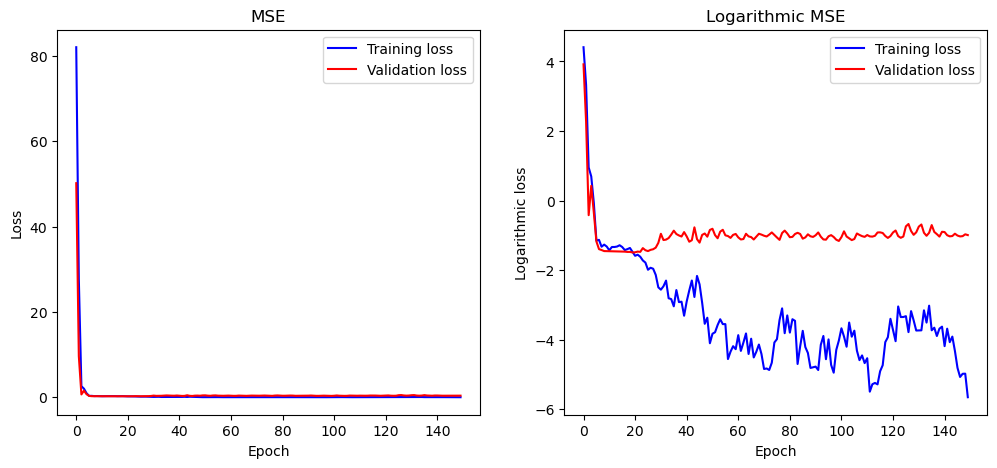

In [21]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12, 5))
fig.add_subplot(1, 2, 1)
plt.plot(np.asarray(hist_train), 'b', label="Training loss")
plt.plot(np.asarray(hist_valid), 'r', label="Validation loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title("MSE")
plt.legend()

fig.add_subplot(1, 2, 2)
plt.plot(np.log(np.asarray(hist_train)), 'b', label="Training loss")
plt.plot(np.log(np.asarray(hist_valid)), 'r', label="Validation loss")
plt.xlabel('Epoch')
plt.ylabel('Logarithmic loss')
plt.title("Logarithmic MSE")
plt.legend()

plt.show()

In [22]:
# save the checkpoint model training
output_path = "../models/"

torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss.item()
            }, Path(output_path,'autoencoder_train_checkpoint.pt'))

RuntimeError: Parent directory ../models does not exist.

#### Evaluate model
Now we can evaluate our model with testing set and compare the predictions with the ground truth.

In [ ]:
# switch model into evaluation mode
model.eval()
hist_test = []
predictions = []
hist_test_step = 0
for batch_idx, (X_batch, y_batch) in enumerate(test_loader):
    var_X_batch = torch.autograd.Variable(X_batch).to(device)
    var_y_batch = torch.autograd.Variable(y_batch).to(device)
    optimizer.zero_grad()
    with torch.no_grad():
        output = model(var_X_batch)
        loss = criterion(output.squeeze(), var_y_batch)
    wandb.log({'testing_loss': loss.item()})
    predictions.append(output.squeeze().cpu().detach().numpy())
    hist_test_step += loss.item()

hist_test.append(hist_test_step / len(test_loader.dataset))
# call wandb finish to stop logging
wandb.finish()

testing_loss,█▇▁
train_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
validation_loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
testing_loss,0.29413
train_loss,0.07743
validation_loss,0.5721


In [42]:
print(f"The MSE loss is {hist_test[0]:.3f}")

fig = plt.figure()
instances = np.arange(len(np.concatenate(predictions)))
plt.scatter(instances, np.concatenate(predictions), label="Predictions")
plt.scatter(instances, test_y_torch.numpy(), label="Ground truth")
plt.xlabel("Experiment")
plt.ylabel("TS")
plt.legend()
plt.show()

NameError: name 'hist_test' is not defined

In [ ]:
print(f"The MSE loss is {hist_test[0]:.3f}")

fig, ax = plt.subplots(figsize=(12, 5))

instances = np.arange(len(np.concatenate(predictions)))
ground_truth = target_series_sel[:,-1][-test_samples:]
ax.plot(ground_truth.anchor_year, ground_truth.values.ravel(), label="Ground truth")
ax.scatter(ground_truth.anchor_year, np.concatenate(predictions), label="Predictions")
plt.xlabel("(Anchor) Year")
plt.ylabel("Temperature [degree C]")
plt.legend()
plt.show()